In [115]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import dask
import datetime

In [116]:
M = 0.8 #change later
reference_fuel_consumption = 0.7296 #who knows
reference_nox = 19.1835 #IDGAF
number_of_engines = 2 
temp_sea_level = 288.15 #kelvins
pres_sea_level = 101325 #pascals
gamma = 1.4
R = 287.05


In [117]:
#merge echam, accf and contrail datasets for each month into datasets representing whole year
directory = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal")
dir = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal"
echam_files = []
accf_files = []
contrail_files = []
airtraf_files = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("ECHAM5.nc"):
        echam_files.append(os.path.join(dir, filename))
    elif filename.endswith("accf_gp.nc"):
        accf_files.append(os.path.join(dir, filename))
    elif filename.endswith("contrail_gp.nc"):
        contrail_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_gp.nc"):
        airtraf_files.append(os.path.join(dir, filename))
    else:
        continue
if echam_files:
    merged_echam = xr.open_mfdataset(echam_files, combine='nested', concat_dim='time')
if accf_files:
    merged_accf = xr.open_mfdataset(accf_files, combine='nested', concat_dim='time')
if contrail_files:
    merged_contrail = xr.open_mfdataset(contrail_files, combine='nested', concat_dim='time')
if airtraf_files:
    merged_airtraf = xr.open_mfdataset(airtraf_files, combine='nested', concat_dim='time')
 

In [118]:
#taking 2018 as the only time period
merged_echam = merged_echam.sel(time = slice("2018-01-01", "2018-12-31"))
merged_accf = merged_accf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_contrail = merged_contrail.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf = merged_airtraf.sel(time = slice("2018-01-01", "2018-12-31"))
#calculates mean for each month and creates new dataarrays
merged_echam_compressed = []
merged_accf_compressed = []
merged_contrail_compressed = []
merged_airtraf_compressed = []
for i in range(1,13):
    merged_echam_compressed.append(merged_echam.sel(time=merged_echam['time.month'] == i).mean(dim='time'))
    merged_accf_compressed.append(merged_accf.sel(time=merged_accf['time.month'] == i).mean(dim='time'))
    merged_contrail_compressed.append(merged_contrail.sel(time=merged_contrail['time.month'] == i).mean(dim='time'))
    merged_airtraf_compressed.append(merged_airtraf.sel(time=merged_airtraf['time.month'] == i).mean(dim='time'))
merged_echam_compressed = xr.concat(merged_echam_compressed, dim='time')
merged_accf_compressed = xr.concat(merged_accf_compressed, dim='time')
merged_contrail_compressed = xr.concat(merged_contrail_compressed, dim='time')
merged_airtraf_compressed = xr.concat(merged_airtraf_compressed, dim='time')
#months go from '1-12', the index starts at '0' as for all arrays

In [119]:
#aircrafts velocity based on its mach number
velocity = M*np.sqrt(gamma*R*merged_echam_compressed['tm1']) #m/s
#correction coefficients for fuel consumption
delta = merged_echam_compressed['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta = merged_echam_compressed['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i = reference_fuel_consumption*delta*np.sqrt(theta) #kg/s
#total fuel consumption
f_cr = f_a_i*number_of_engines #kg/s
#humidity correction coefficient
H_c = np.exp(-19*(merged_echam_compressed['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x = reference_nox*delta**0.4*theta**0.3*H_c #g/kg
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm = merged_accf_compressed['atr20_co2']/velocity*f_cr*1000 #K/km
h2o_atr20_perkm = merged_accf_compressed['atr20_h2o']/velocity*f_cr*1000 #K/km
o3_atr20_perkm = merged_accf_compressed['atr20_o3']/velocity*f_cr*EINO_x*10**(-3)*1000 #K/km
ch4_atr20_perkm = merged_accf_compressed['atr20_ch4']/velocity*f_cr*EINO_x*10**(-3)*1000 #K/km
contr_atr20_perkm = merged_accf_compressed['atr20_contrail']*merged_contrail_compressed['potcov'] #?
total_atr20_perkm = co2_atr20_perkm + h2o_atr20_perkm + o3_atr20_perkm + ch4_atr20_perkm + contr_atr20_perkm


In [120]:
#aircrafts velocity based on its mach number
velocity_uncompressed = M*np.sqrt(gamma*R*merged_echam['tm1']) #m/s
#correction coefficients for fuel consumption
delta_uncompressed = merged_echam['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta_uncompressed = merged_echam['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i_uncompressed = reference_fuel_consumption*delta_uncompressed*np.sqrt(theta_uncompressed) #kg/s
#total fuel consumption
f_cr_uncompressed = f_a_i_uncompressed*number_of_engines #kg/s
#humidity correction coefficient
H_c_uncompressed = np.exp(-19*(merged_echam['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x_uncompressed = reference_nox*delta_uncompressed**0.4*theta_uncompressed**0.3*H_c_uncompressed #g/kg
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm_uncompressed = merged_accf['atr20_co2']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
h2o_atr20_perkm_uncompressed = merged_accf['atr20_h2o']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
o3_atr20_perkm_uncompressed = merged_accf['atr20_o3']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
ch4_atr20_perkm_uncompressed = merged_accf['atr20_ch4']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
contr_atr20_perkm_uncompressed = merged_accf['atr20_contrail']*merged_contrail['potcov'] #?
total_atr20_perkm_uncompressed = co2_atr20_perkm_uncompressed + h2o_atr20_perkm_uncompressed + o3_atr20_perkm_uncompressed + ch4_atr20_perkm_uncompressed + contr_atr20_perkm_uncompressed


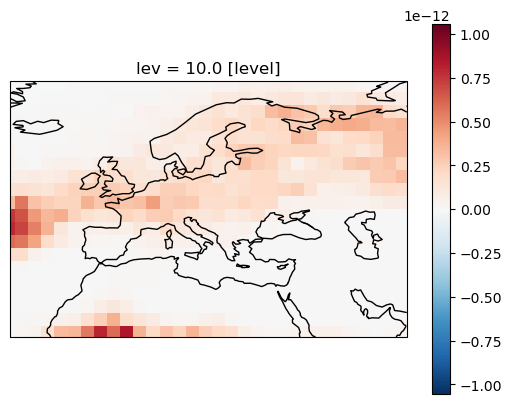

In [56]:
var = contr_atr20_perkm.isel(time=6).sel(lev=10.0)
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

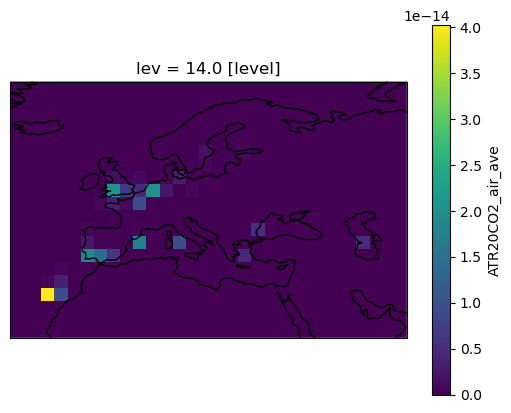

In [36]:
#lev range 8-14
var = merged_airtraf_compressed['ATR20CO2_air_ave'].isel(time=5).sel(lev=14.0)
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

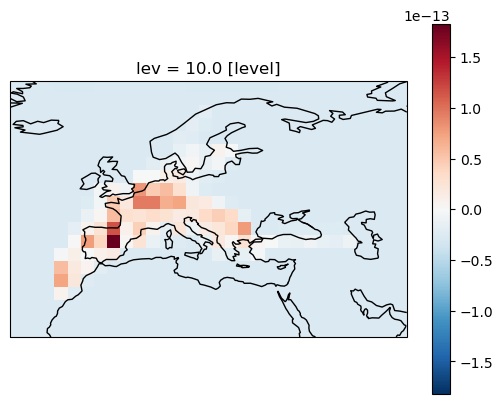

In [9]:
testing =  merged_airtraf_compressed['ATR20CO2_air_ave']/velocity * 1000 - co2_atr20_perkm
var = testing.isel(time=5).sel(lev=10.0)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

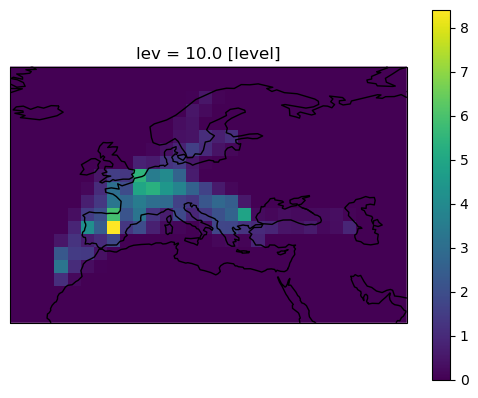

In [10]:
test_route = xr.open_dataset("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal/f100___________20180101_0000_airtraf_gp.nc")
test_route = test_route.mean(dim='time')
ratio = test_route['ATR20CO2_air_ave']/(co2_atr20_perkm.isel(time = 0)*velocity.isel(time = 0)) * 1000
var = ratio.sel(lev=10.0)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

In [38]:
airtraf_check = xr.open_dataset("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal/f100___________20180101_0000_airtraf_ac_rr.nc")
airtraf_check


<xarray.Dataset>
Dimensions:              (time: 31, lon: 128, lat: 64, AirTraf_routes: 100,
                          AirTraf_properties: 16, AirTraf_waypoints: 101,
                          AirTraf_routes_desc: 11, tbnds: 2)
Coordinates:
  * time                 (time) datetime64[ns] 2018-01-01 ... 2018-01-31
  * lon                  (lon) float32 0.0 2.812 5.625 ... 351.6 354.4 357.2
  * lat                  (lat) float32 87.86 85.1 82.31 ... -82.31 -85.1 -87.86
Dimensions without coordinates: AirTraf_routes, AirTraf_properties,
                                AirTraf_waypoints, AirTraf_routes_desc, tbnds
Data variables:
    YYYYMMDD             (time) float64 ...
    dt                   (time) float64 ...
    nstep                (time) float64 ...
    routes_rerun         (time, AirTraf_routes, AirTraf_properties, AirTraf_waypoints) float32 ...
    routes_rerun_info_r  (time, AirTraf_routes, AirTraf_properties) float32 ...
    routes_rerun_info_i  (time, AirTraf_routes, AirTraf_properties) float32 ...
    routes_rerun_desc    (time, AirTraf_routes_desc, AirTraf_routes) float32 ...
    aps                  (time, lat, lon) float32 ...
    time_bnds            (time, tbnds) datetime64[ns] ...
Attributes: (12/49)
    MESSy:                    MESSy version d2.55.2, http://www.messy-interfa...
    MESSy_switch:             version 1.0
    MESSy_channel:            version 2.4.4
    MESSy_tracer:             version 2.6
    MESSy_timer:              version 0.1
    MESSy_qtimer:             version 3.0
    ...                       ...
    channel_io_pe:            0
    channel_time_slo:         171360.0
    channel_name:             airtraf_ac_rr
    channel_file_type:        output
    channel_file_name:        f100___________20180101_0000_airtraf_ac_rr.nc
    channel_netcdf_lib:       4.3.3.1 of Dec 10 2015 16:44:18 $

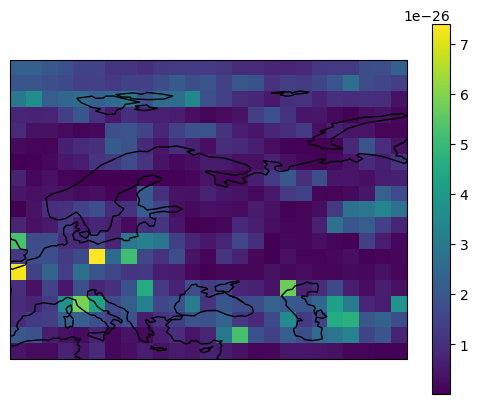

In [112]:

#var = total_atr20_perkm.sel(time=0).sel(lev=slice(8, 14)).sel(lon=slice(0, 67.5), lat=slice(87.8638,32.091946)).var(dim='lev')
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

#extent = [-25, 60, 20, 70]
#ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

In [153]:
time = total_atr20_perkm_uncompressed.coords['time'].values
total_atr20_perkm_uncompressed_mean = total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).mean(dim=['time','lev'], keep_attrs=True).expand_dims(dim='time', time)
# total_atr20_perkm_uncompressed_sd = total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).std(dim=['time','lev'])
var = (total_atr20_perkm_uncompressed.sel(lev=slice(8,14)) - total_atr20_perkm_uncompressed_mean)
# var = var / total_atr20_perkm_uncompressed_sd
var = var.sel(time=0)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

#extent = [-25, 60, 20, 70]
#ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)




SyntaxError: positional argument follows keyword argument (3049161951.py, line 2)

In [138]:
time = np.arange[datetime(2018,1,1)

total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).mean(dim=['time','lev']).expand_dims('time')

<xarray.DataArray (time: 1, lat: 64, lon: 128)>
dask.array<broadcast_to, shape=(1, 64, 128), dtype=float64, chunksize=(1, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float32 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
Dimensions without coordinates: time

In [148]:
total_atr20_perkm_uncompressed_mean = total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).mean(dim=['time','lev'], keep_attrs=True)
# total_atr20_perkm_uncompressed_sd = total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).std(dim=['time','lev'])
var = total_atr20_perkm_uncompressed.sel(lev=slice(8,14)).apply(lambda x: x - total_atr20_perkm_uncompressed_mean)
# var = var / total_atr20_perkm_uncompressed_sd
var = var.sel(time=0)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

#extent = [-25, 60, 20, 70]
#ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)


AttributeError: 'DataArray' object has no attribute 'apply'

In [141]:
mean

<xarray.DataArray (time: 365, lev: 7, lat: 64, lon: 128)>
dask.array<getitem, shape=(365, 7, 64, 128), dtype=float64, chunksize=(31, 7, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float32 8.0 9.0 10.0 11.0 12.0 13.0 14.0
  * lat      (lat) float32 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86

In [149]:
total_atr20_perkm_uncompressed.coords['time'].values

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28